---
## Song genre prediction
> - 노래 가사를 이용해서 장르를 예측하는 모델.  
- 16800곡의 노래를 {'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Rock'} 7장르에 대해 예측.  
- nltk, word2vec을 이용해 노래의 200단어만 특수문자 제외하고 tokenizing 후 embedding

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import tensorflow as tf
from pprint import pprint

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import nltk
from gensim import models, similarities

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


---
## 메모리 부족때문에 전처리와 학습 과정 분리
> 전처리후 저장해둔 csv, w2v model로드

In [3]:
# 전처리한 데이터 로드
df2 = pd.read_csv('lyrics_refine.csv')
# 저장한 w2v 모델 로드
model = models.word2vec.Word2Vec.load('models/word2vec.model')

In [6]:
# 전처리된 데이터 예시
df2.head()
# df2['tok'][100]

,genre,tok
0,Pop,oh baby how you doing you know i m gonna cut r...
1,Pop,playin everything so easy it s like you seem s...
2,Pop,oh oh oh i oh oh oh i verse if i wrote a book ...
3,Pop,party the people the people the party it s pop...
4,Pop,this is just another day that i would spend wa...


In [7]:
# 원본 데이터 비율 유지한 테스트셋 만들기
empty = [0]*len(df2)
df2, df2_for_test, no, no_ = train_test_split(df2, empty, test_size=0.1, random_state=3)

{'Pop', 'Metal', 'Rock', 'Electronic', 'Jazz', 'Hip-Hop', 'Country'}


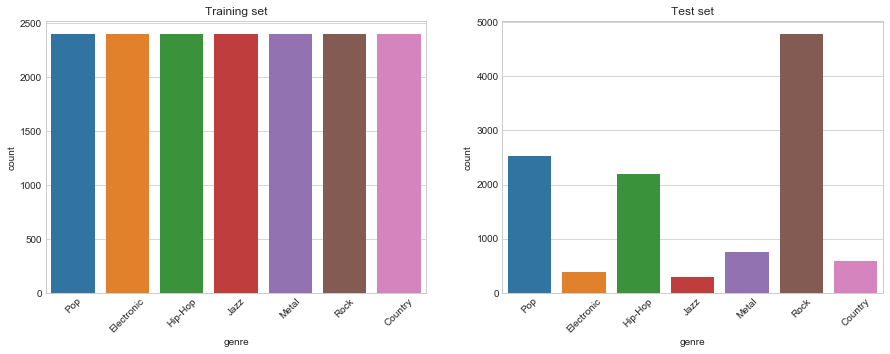

In [13]:
# train/test set 비율 확인
order = df2['genre'].value_counts().index
plt.subplots(figsize=(15,5))
plt.subplot(121)
plt.title('Training set')
plt.xticks(rotation=45)
sns.countplot(x=df2['genre'], order = order)
plt.subplot(122)
plt.title('Test set')
plt.xticks(rotation=45)
sns.countplot(x=df2_for_test['genre'], order = order)
print(set(df2['genre']))

# df2_for_test['genre'].value_counts().plot(kind='bar')

In [14]:
# 레이블 최소, 최대 개수 확인
print(len(df2[df2['genre'] ==  'Jazz']), len(df2[df2['genre'] ==  'Rock']), 
      len(df2_for_test[df2_for_test['genre'] ==  'Jazz']), len(df2_for_test[df2_for_test['genre'] ==  'Rock']))

2400 2400 284 4785


In [15]:
# tain set 포본 추출
min = 2400
d1 = df2[df2['genre'] == 'Country'][:min]
d2 = df2[df2['genre'] == 'Electronic'][:min]
# d3 = df2[df2['genre'] ==  'Folk']
d4 = df2[df2['genre'] == 'Hip-Hop'][:min]
# d5 = df2[df2['genre'] ==  'Indie']
d6 = df2[df2['genre'] ==  'Jazz'][:min]
d7 = df2[df2['genre'] ==  'Metal'][:min]
# d8 = df2[df2['genre'] ==  'Not Available']
# d9 = df2[df2['genre'] ==  'Other']
d10 = df2[df2['genre'] ==  'Pop'][:min]
# d11 = df2[df2['genre'] ==  'R&B']
d12 = df2[df2['genre'] ==  'Rock'][:min]

In [16]:
# test set 포본 추출
min_ = 280
d1_ = df2_for_test[df2_for_test['genre'] == 'Country'][:min_]
d2_ = df2_for_test[df2_for_test['genre'] == 'Electronic'][:min_]
# d3_ = df2_for_test[df2_for_test['genre'] ==  'Folk']
d4_ = df2_for_test[df2_for_test['genre'] == 'Hip-Hop'][:min_]
# d5_ = df2_for_test[df2_for_test['genre'] ==  'Indie']
d6_ = df2_for_test[df2_for_test['genre'] ==  'Jazz'][:min_]
d7_ = df2_for_test[df2_for_test['genre'] ==  'Metal'][:min_]
# d8_ = df2_for_test[df2_for_test['genre'] ==  'Not Available']
# d9_ = df2_for_test[df2_for_test['genre'] ==  'Other']
d10_ = df2_for_test[df2_for_test['genre'] ==  'Pop'][:min_]
# d11_ = df2_for_test[df2_for_test['genre'] ==  'R&B']
d12_ = df2_for_test[df2_for_test['genre'] ==  'Rock'][:min_]

In [17]:
# 양 적은거 제거 5,3,11,9
df2 = pd.concat([d1,d2,d4,d6,d7,d10,d12], axis=0)
df2_for_test = pd.concat([d1_,d2_,d4_,d6_,d7_,d10_,d12_], axis=0)

In [18]:
print(len(df2), len(df2_for_test))
# df2.head()

16800 1960


In [19]:
set(df2['genre'])

{'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Rock'}

In [20]:
# w2v vector dictionary에 없는 단어 임베딩 위해서 mean값 게산해서 대신 넣음
voc = list(model.wv.vocab)
all_w2v = [model[i] for i in voc]
all_w2v = np.array(all_w2v)

mean = all_w2v.mean(axis=0)
mean.shape
# mean ~ (0,0,0....)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [22]:
# 앞 200단어만 추림
vec = []
for i in df2['tok']:
    arr = i.split(' ')
    temp=[]
    for j in arr[:200]:
        temp.append(j)
    vec.append(temp)

vec_for_test = []
for i in df2_for_test['tok']:
    arr = i.split(' ')
    temp=[]
    for j in arr[:200]:
        temp.append(j)
    vec_for_test.append(temp)

---
## 여기부터 CNN 학습 과정

> 메모리 절약용 제너레이터  
실시간으로 워드 임베딩해서 이전 변수에 덮어씀

In [23]:
# 실제로 사용할 데이터
print('노래 총 개수:', len(vec), len(df2['genre']))

노래 총 개수: 16800 16800


In [24]:
# 각 단어들에 word embedding #row*40000
def tok_embedding(tok_vec):
    w2v_vec = []
    for i in tok_vec: # 그냥 vec넣으면 134170 다들어감 메모리 절대 부족!!! 파이프라인 구축 필요
        temp =[]
        for j in i:
            try:
                temp += list(model[j])
            except:
                temp += list(mean)
        w2v_vec.append(temp)
#     reshape은 텐서플로에서 함
#     w2v_vec = np.array(w2v_vec, dtype='float16')
#     return w2v_vec.reshape([-1,200,embed_dim])
    return w2v_vec

In [25]:
# 피처 데이터, 레이블, 미니배치 갯수
def getMiniBatch(df_, y, n):
    if len(df_) != len(y):
        print('Feature and label num is not equal.')
        return
    start = 0
    while True:
        if start>= len(df_):
#             셔플을 안하니까 좀 되네... -> df, y 묶어서 셔플해야 함
#             df_ = df_.sample(frac=1).reset_index(drop=True) # 1epoch 이후 셔플
            start = 0
        embeded_df = tok_embedding(df_[start: start+n])
        yield embeded_df, y[start: start+n]
#         yield df_[start: start+n], y[start: start+n]   
        start += n 

In [26]:
# 피처 데이터, 레이블, 미니배치 갯수, random sampling
import random
def getMiniBatch2(x, y, n):
    if len(x) != len(y):
        print('Feature and label num is not equal.')
        return
    rand_idx = random.sample(list(range(len(x))), n)
    x_ = [x[i] for i in rand_idx]
    y_ = [y[i] for i in rand_idx]
    return tok_embedding(x_), y_

In [27]:
# 잘 되는지 확인
batch = getMiniBatch(vec, df2['genre'], 200)
a,b = next(batch)
a[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[2.5907738,
 -0.24267168,
 0.54543805,
 -1.2545311,
 1.4652352,
 1.0679761,
 -0.26998866,
 -0.36477175,
 -1.5440143,
 0.8017122,
 0.34499255,
 -0.035264593,
 -1.6692275,
 1.548411,
 0.5486583,
 -0.15295483,
 -0.2653787,
 -0.5668768,
 -2.462996,
 0.37301445,
 1.9796485,
 -0.7783634,
 -2.0179074,
 -0.6398375,
 0.63780403,
 0.0930308,
 -0.38233194,
 0.6954375,
 -0.49751854,
 0.36681858,
 -0.08898491,
 1.5208442,
 1.5172831,
 -2.5015554,
 -1.0142654,
 0.64074314,
 -0.15971485,
 1.4012601,
 -2.0971606,
 0.46608478,
 -0.37746072,
 -1.9444294,
 -0.27135035,
 1.8618072,
 -1.6353933,
 0.38747427,
 -1.288988,
 -0.74081653,
 2.3801374,
 0.09847989,
 -0.07050768,
 1.4659917,
 -1.3420361,
 -0.7279636,
 -1.4321383,
 0.53688616,
 -2.5676124,
 0.46852374,
 -0.7851168,
 -1.2410642,
 -0.18491781,
 -0.41279513,
 1.5698236,
 -2.1528916,
 -0.04733863,
 -1.3974521,
 3.0105495,
 -0.58291024,
 -1.6563672,
 1.4047805,
 1.2918812,
 -1.1241627,
 0.71988285,
 0.863628,
 -1.1349491,
 0.5035838,
 -0.8638479,
 -1.19

---
## lable 전처리

In [28]:
# genre: 카테고리 -> 숫자로 변경
# genre = {'Electronic':0, 'Jazz':1, 'Metal':2, 'Not Available':3, 'Other':4,
#          'Country':5, 'R&B':6, 'Pop':7, 'Rock':8, 'Indie':9, 'Folk':10, 'Hip-Hop':11}
genre = {'Electronic':0, 'Jazz':1, 'Metal':2, 
         'Country':3, 'Pop':4, 'Rock':5, 'Hip-Hop':6}
label = [genre[i] for i in df2['genre']]
label_for_test = [genre[i] for i in df2_for_test['genre']]

In [29]:
X_all = vec
Y_all = label

In [30]:
# 실험용 데이터 1/10로 줄이는 부분
# X2, _, Y2, __ = train_test_split(X, Y, test_size=1, random_state=3)

In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.02, random_state=3)

{0, 1, 2, 3, 4, 5, 6}


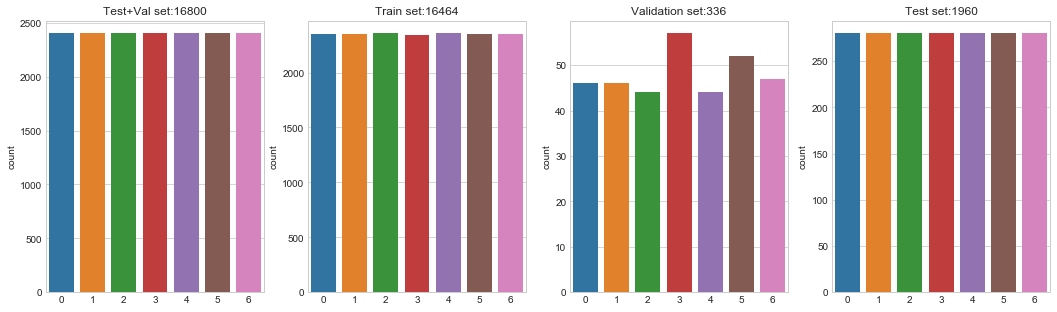

In [32]:
# data label 분포확인 
order = list(range(len(set(Y_all))))
plt.subplots(figsize=(18,5))
plt.subplot(141)
plt.title('Test+Val set:%d'%len(Y_all))
sns.countplot(x=Y_all, order = order)
plt.subplot(142)
plt.title('Train set:%d'%len(X_train))
sns.countplot(x=Y_train, order = order)
plt.subplot(143)
plt.title('Validation set:%d'%len(X_val))
sns.countplot(x=Y_val, order = order)
plt.subplot(144)
plt.title('Test set:%d'%len(label_for_test))
sns.countplot(x=label_for_test, order = order)
print(set(Y_all))

In [33]:
sess = tf.InteractiveSession()
Y_train = sess.run(tf.one_hot(Y_train, len(set(Y_all))))
Y_val = sess.run(tf.one_hot(Y_val, len(set(Y_all))))
label_for_test_onehot = sess.run(tf.one_hot(label_for_test, len(set(Y_all))))
print([len(X_train),len(X_train[0])], [len(Y_train),len(Y_train[0])], [len(X_val),len(X_val[0])], [len(Y_val),len(Y_val[0])], len(label_for_test_onehot))

[16464, 200] [16464, 7] [336, 200] [336, 7] 1960


### CNN 그래프 만들기

In [34]:
tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

# hyper parameters
learning_rate = 0.002
batch_size = 100
epoch = 6
lyric_size = 200
embed_dim = 200
lable_dim = len(Y_train[0])
dropout = 0.5
kernel = 150
ALPHA = 0.01

# input place holders
X = tf.placeholder(tf.float32, [None, lyric_size*embed_dim]) # 인풋은 1차원 벡터가 배치로 들어감
Y = tf.placeholder(tf.float32, [None, lable_dim])
X_img = tf.reshape(X, [-1, lyric_size, embed_dim, 1]) # (batch, row, column, channel)

# kernel size 3
W1 = tf.Variable(tf.random_normal([3, embed_dim, 1, kernel], stddev=0.01)) # (row, column, channel, #kernel)
#    Conv     -> (?, 200-2, 1, 150)
#    Pool     -> (?, 1, 1, 150)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='VALID')
L1 = tf.nn.tanh(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, (lyric_size-2), 1, 1],
                    strides=[1, 1, 1, 1], padding='VALID')
# <tf.Tensor 'MaxPool:0' shape=(?, 1, 1, 150) dtype=float32>

# kernel size 4
W12 = tf.Variable(tf.random_normal([4, embed_dim, 1, kernel], stddev=0.01))
#    Conv     -> (?, 200-3, 1, 150)
#    Pool     -> (?, 1, 1, 150)
L12 = tf.nn.conv2d(X_img, W12, strides=[1, 1, 1, 1], padding='VALID')
L12 = tf.nn.tanh(L12)
L12 = tf.nn.max_pool(L12, ksize=[1, (lyric_size-3), 1, 1],
                    strides=[1, 1, 1, 1], padding='VALID')
# <tf.Tensor 'MaxPool:0' shape=(?, 1, 1, 150) dtype=float32>

# kernel size 5
W13 = tf.Variable(tf.random_normal([5, embed_dim, 1, kernel], stddev=0.01))
#    Conv     -> (?, 200-4, 1, 150)
#    Pool     -> (?, 1, 1, 150)
L13 = tf.nn.conv2d(X_img, W13, strides=[1, 1, 1, 1], padding='VALID')
L13 = tf.nn.tanh(L13)
L13 = tf.nn.max_pool(L13, ksize=[1, (lyric_size-4), 1, 1],
                    strides=[1, 1, 1, 1], padding='VALID')
# <tf.Tensor 'MaxPool:0' shape=(?, 1, 1, 150) dtype=float32>

L2_flat = tf.concat([L1, L12, L13], 3) # (?, 1, 1, 150*3)
L2_flat = tf.reshape(L2_flat, [-1, 3 * kernel]) # (?, 150*3)

# fully connected network
keep_prob = tf.placeholder(tf.float32)
W3 = tf.get_variable("W3", shape=[3*kernel, 400], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([400]))
L3 = tf.nn.relu(tf.matmul(L2_flat, W3)+b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

# W4 = tf.get_variable("W4", shape=[400, lable_dim], initializer=tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable("W4", shape=[400, lable_dim], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([lable_dim]))
hypothesis = tf.nn.softmax(tf.matmul(L3, W4)+b4)


cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), axis=1))
# Regularization
regularzers = tf.nn.l2_loss(W3)
cost = tf.reduce_mean(cost+regularzers*ALPHA)

# train_step = tf.train.GradientDescentOptimizer(learning_rate= learning_rate).minimize(cost)
train_step = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)

predicted = tf.argmax(hypothesis, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

total_iter = epoch*int(len(X_train)/batch_size) # 총 학습횟수
print('total iteration:', total_iter, '...')

total iteration: 984 ...


In [35]:
# accuracy_, cost_ 계산하는 함수
# prop 전체 테스트셋에서 몇 %나 사용할지
def calc_acc_cost(x, y, prop):
    accuracy_ = 0
    cost_ = 0
    batch_size = int(len(y)*prop)
    # 계속 같은 데이터 부분만 사용할것
    batch_for_acc = getMiniBatch(x, y, batch_size)
    x_acc, y_acc = next(batch_for_acc)
    a, c = sess.run([accuracy, cost], feed_dict={X:x_acc, Y:y_acc, keep_prob:1})
    return a, c

In [36]:
s_time = time.time()
#----------------------
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
val_costs=[]
X_val_tok = tok_embedding(X_val)

for i in range(total_iter):
    X_, Y_ = getMiniBatch2(X_train, Y_train, batch_size) # 랜덤 미니배치 할당
    train_step.run(feed_dict={X:X_, Y:Y_, keep_prob:dropout})

#   아래에 결과 프린트용
    if i % 10 == 0:   
        train_accuracy = accuracy.eval(feed_dict={X:X_, Y:Y_, keep_prob:1})
        val_accuracy, val_cost = sess.run([accuracy, cost], feed_dict={X:X_val_tok, Y:Y_val, keep_prob:1})
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_costs.append(val_cost)
        x_range.append(i)
        print('step %d: acc_tr %g, acc_tt %g, val_cost %g' % (i, train_accuracy, val_accuracy, val_cost))
# -------------------------
e_time = time.time()
print('training time: %s sec' %(e_time - s_time))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


step 0: acc_tr 0.15, acc_tt 0.130952, val_cost 5.21807
step 10: acc_tr 0.2, acc_tt 0.214286, val_cost 3.42062
step 20: acc_tr 0.38, acc_tt 0.300595, val_cost 3.04043
step 30: acc_tr 0.36, acc_tt 0.324405, val_cost 2.7828
step 40: acc_tr 0.41, acc_tt 0.333333, val_cost 2.60091
step 50: acc_tr 0.36, acc_tt 0.375, val_cost 2.5086
step 60: acc_tr 0.42, acc_tt 0.348214, val_cost 2.38075
step 70: acc_tr 0.44, acc_tt 0.425595, val_cost 2.26428
step 80: acc_tr 0.44, acc_tt 0.372024, val_cost 2.22679
step 90: acc_tr 0.49, acc_tt 0.386905, val_cost 2.13047
step 100: acc_tr 0.49, acc_tt 0.425595, val_cost 2.07349
step 110: acc_tr 0.33, acc_tt 0.386905, val_cost 2.02388
step 120: acc_tr 0.47, acc_tt 0.386905, val_cost 1.95383
step 130: acc_tr 0.4, acc_tt 0.46131, val_cost 1.90315
step 140: acc_tr 0.55, acc_tt 0.428571, val_cost 1.85825
step 150: acc_tr 0.55, acc_tt 0.422619, val_cost 1.88257
step 160: acc_tr 0.54, acc_tt 0.431548, val_cost 1.78681
step 170: acc_tr 0.53, acc_tt 0.422619, val_cost 1

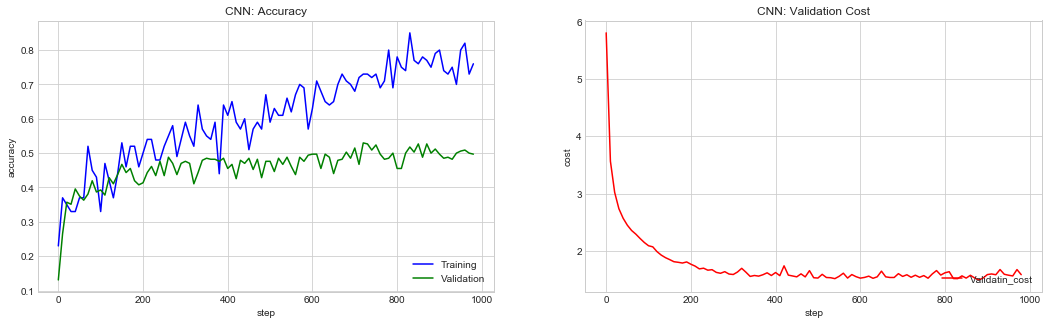

In [32]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('CNN: Accuracy')

plt.subplot(122)
plt.plot(x_range, val_costs,'-r', label='Validatin_cost')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('cost')
plt.xlabel('step')
plt.title('CNN: Validation Cost')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


98% calculated
except occured

except occured

test set accuracy:  0.4520408163265306
[[0.39 0.17 0.07 0.05 0.16 0.1  0.06]
 [0.08 0.48 0.02 0.25 0.09 0.06 0.02]
 [0.14 0.04 0.57 0.05 0.02 0.12 0.06]
 [0.02 0.16 0.   0.67 0.06 0.08 0.01]
 [0.2  0.24 0.02 0.12 0.24 0.11 0.06]
 [0.12 0.24 0.08 0.26 0.08 0.19 0.03]
 [0.13 0.06 0.03 0.04 0.09 0.02 0.62]]


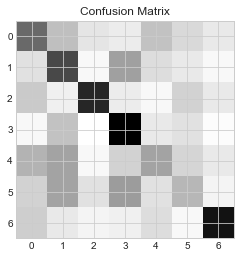

In [34]:
# test set data 예측 정확도

xxx = []
yyy = []
bat = round(len(vec_for_test)/100+0.5)
start = 0
end = bat
for i in range(100):
    X_all_test = tok_embedding(vec_for_test[start:end])
    try:
        xxx.extend(predicted.eval(feed_dict={X:X_all_test, keep_prob:1}))
        yyy.extend(sess.run(tf.argmax(label_for_test_onehot[start:end], 1)))
        start += bat
        end += bat
        print('\r%d%% calculated'%(i+1), end='')
    except:
        print('\nexcept occured')
        
# 레이블별 정확도 시각적으로 보기
dim = len(label_for_test_onehot[0])
image = np.zeros(dim*dim)

for i, el in enumerate(xxx):
    cell = el+yyy[i]*dim
    image[cell] +=1

dist = image.reshape(dim,dim).round(0)
dist_avg = (dist.T/dist.sum(axis=1)).T
dist_avg = dist_avg.round(2)
acc_test = sum(dist.diagonal())/len(vec_for_test)    
print('\ntest set accuracy: ',acc_test)
print(dist_avg)
plt.title('Confusion Matrix')
plt.imshow(dist_avg, cmap='binary')